<a href="https://colab.research.google.com/github/Alanazi433/GenAI/blob/main/HW3/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat


--2024-10-09 11:54:25--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  2.55MB/s    in 57s     

2024-10-09 11:55:23 (3.02 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-10-09 11:55:23--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  1.97MB/s    in 29s     

2024-10-09 11:55:52 (2.13 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [ ]:
!pip install tensorflow numpy scipy matplotlib

In [ ]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import losses


In [ ]:
!pip install tensorflow==2.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 42.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation:

In [ ]:
# Load training and testing data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')


In [ ]:
from scipy.io import loadmat
import numpy as np

# Load data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

# Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()

# Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')


Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


In [ ]:
from tensorflow.keras import layers, Model, Input

def create_encoder(latent_dim, input_shape=(32, 32, 3)):
    encoder_input = Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(encoder_input)
    x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    # Latent space representation
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    return Model(encoder_input, [z_mean, z_log_var], name="encoder")


In [ ]:
def create_decoder(latent_dim):
    decoder_input = Input(shape=(latent_dim,))
    x = layers.Dense(8 * 8 * 64, activation='relu')(decoder_input)
    x = layers.Reshape((8, 8, 64))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
    decoder_output = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(decoder_input, decoder_output, name="decoder")


In [ ]:
from tensorflow.keras import backend as K

def sampling(z_mean, z_log_var):
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [ ]:
def build_vae(latent_dim, input_shape=(32, 32, 3)):
    encoder = create_encoder(latent_dim, input_shape)
    decoder = create_decoder(latent_dim)

    z_mean, z_log_var = encoder(encoder.input)
    z = sampling(z_mean, z_log_var)
    vae_output = decoder(z)
    vae = Model(encoder.input, vae_output, name="VAE")

    # Define the VAE loss
    reconstruction_loss = K.mean(K.square(K.flatten(encoder.input) - K.flatten(vae_output)))
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)

    vae.add_loss(vae_loss)
    return vae


In [ ]:
from tensorflow.keras import losses

latent_dims = [2, 5, 10]

for dim in latent_dims:
    print(f'Training VAE with latent dimension: {dim}')
    vae = build_vae(latent_dim=dim)
    vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
    history = vae.fit(
        x_train,               # Input data
        x_train,               # Target data (reconstruction)
        epochs=50,             # Train for 50 epochs
        batch_size=128,        # Batch size
        validation_data=(x_test, x_test)  # Validation data
    )


Training VAE with latent dimension: 2
Epoch 1/50
573/573 [==============================] - 22s 36ms/step - loss: 0.7281 - val_loss: 0.7403
Epoch 2/50
573/573 [==============================] - 20s 34ms/step - loss: 0.7274 - val_loss: 0.7402
Epoch 3/50
573/573 [==============================] - 19s 34ms/step - loss: 0.7274 - val_loss: 0.7407
Epoch 4/50
573/573 [==============================] - 19s 34ms/step - loss: 0.7274 - val_loss: 0.7403
Epoch 5/50
573/573 [==============================] - 20s 34ms/step - loss: 0.7274 - val_loss: 0.7403
Epoch 6/50
573/573 [==============================] - 20s 34ms/step - loss: 0.7274 - val_loss: 0.7403
Epoch 7/50
573/573 [==============================] - 20s 35ms/step - loss: 0.7274 - val_loss: 0.7405
Epoch 8/50
573/573 [==============================] - 20s 35ms/step - loss: 0.7274 - val_loss: 0.7404
Epoch 9/50
573/573 [==============================] - 20s 36ms/step - loss: 0.7274 - val_loss: 0.7404
Epoch 10/50
573/573 [=======================

In [ ]:
import matplotlib.pyplot as plt

def visualize_reconstruction(vae, x_test, num_images=10):
    # Randomly select images from the test set
    idx = np.random.randint(0, x_test.shape[0], num_images)
    x_orig = x_test[idx]
    x_recon = vae.predict(x_orig)

    # Plot original and reconstructed images
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Display original image
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(x_orig[i])
        plt.title("Original")
        plt.axis("off")

        # Display reconstructed image
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(x_recon[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()


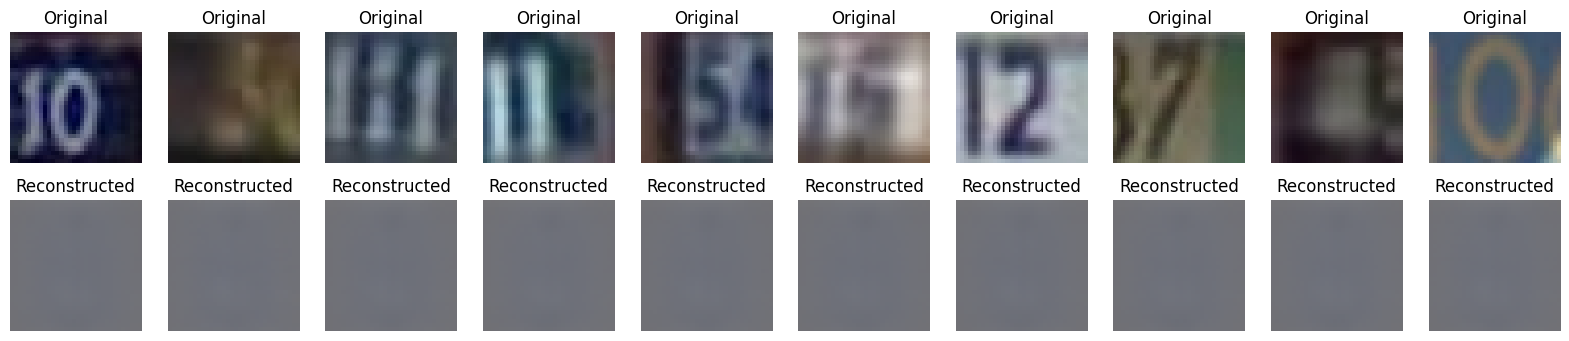

In [ ]:
# Assuming `vae` is the trained model with latent dimension = 10
visualize_reconstruction(vae, x_test, num_images=10)
